In [32]:
from IPython.display import display

from notebooks.util.long_memory_utils import *
from liquidity.util.utils import compute_returns

from powerlaw_function.powerlaw_function import Fit

from hurst_exponent.hurst_exponent import standard_hurst, generalized_hurst
from hurst_exponent.util.utils import interpret_hurst, augmented_dickey_fuller

In [33]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Number of events to use
EVENTS_RANGE = 100000

# Number of lags for the ACF
ACF_RANGE = 1001

# Lag/window size for Hurst
LAG = 100

## Load raw sample data

In [35]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')
acf_data_dir = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'long_memory')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

## 1. Compute Returns

In [36]:
# Compute returns
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']

returns = {
  'TSLA': tsla_returns,
  'MSFT': msft_returns,
  'AMZN': amzn_returns,
  'NFLX': nflx_returns,
  'EBAY': ebay_returns,
  'APPL': appl_returns
}
returns = {stock: data.head(EVENTS_RANGE) for stock, data in returns.items()}

In [37]:
# Compute ACF for TSLA using the linear method
tsla_acf = compute_acf("TSLA", tsla_returns, option="linear")
display(tsla_acf)

('TSLA',
 0       1.000000
 1      -0.015541
 2       0.001610
 3       0.005973
 4       0.005574
           ...   
 996    -0.001168
 997     0.000533
 998     0.001713
 999    -0.000517
 1000   -0.000748
 Length: 1001, dtype: float64)

## 2. Stationarity Test

To test whether our time series are stationary, we perform an augmented Dickey-Fuller test on each series, which uses the following null and alternative hypotheses:

- **H0:** The time series is non-stationary.
  - In other words, it has some time-dependent structure and does not have constant variance over time.
  - There is at least one unit root.

- **H1:** The time series is stationary.

- **Note:** If the p-value from the test is less than some significance level (e.g. $\alpha$ = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [38]:
# ADF test
for stock, data in returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -320.14
p-value: 0.00,
N: 99999, 
critical values: {'1%': -3.4304153953326493, '5%': -2.8615689037124814, '10%': -2.566785384434747}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -319.31
p-value: 0.00,
N: 99999, 
critical values: {'1%': -3.4304153953326493, '5%': -2.8615689037124814, '10%': -2.566785384434747}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -322.06
p-value: 0.00,
N: 99999, 
critical values: {'1%': -3.4304153953326493, '5%': -2.8615689037124814, '10%': -2.566785384434747}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -178.95
p-value: 0.00,
N: 99997, 
critical values: {'1%': -3.4304153966406288, '5%': -2.8615689042905816, '10%': -2.5667853847424507}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



## 3. Autocorrelation Functions

There appears to be a clear difference between linear and nonlinear ACFs. If our data doesn’t contain significant non-linear patterns, both Pearson and Kendall methods could end up providing similar results.

**Key Points:**
- The **Kendall correlation** would detect non-linear relationships if they exist.
- If no non-linear relationships exist, it would just mirror the results of the Pearson correlation.
- Given this behavior, it’s best to use **Kendall** in case a non-linear relation holds for some data in our sample.


In [39]:
# # Save data for lazy loading
linear_filename = f"{acf_data_dir}/mo_returns_linear_acfs.pkl"
nonlinear_filename = f"{acf_data_dir}/mo_returns_nonlinear_acfs.pkl"

# Linear ACF
linear_acfs = compute_acfs(filename=linear_filename, data=returns, option='linear')
print(linear_acfs.keys())

# Nonlinear ACF
nonlinear_acfs = compute_acfs(filename=nonlinear_filename, data=returns, option='nonlinear')
print(nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [40]:
# Let's assume you've got returns for multiple stocks in a dictionary format
returns = {
  'TSLA': tsla_returns,
  'MSFT': msft_returns,
  'AMZN': amzn_returns,
  # ... add as many stocks as you have
}

# Filename to save/load computed ACFs
filename = "computed_acfs.pkl"

# Compute (or load) ACFs for all stocks in parallel using the linear method
all_acfs = compute_acfs(filename, returns, option="linear")

print(all_acfs)

{'TSLA': 0       1.000000
1      -0.015541
2       0.001610
3       0.005973
4       0.005574
          ...   
996    -0.001168
997     0.000533
998     0.001713
999    -0.000517
1000   -0.000748
Length: 1001, dtype: float64, 'MSFT': 0       1.000000
1      -0.012089
2      -0.000513
3       0.002015
4       0.000918
          ...   
996    -0.001260
997     0.000577
998     0.001008
999    -0.000427
1000   -0.000014
Length: 1001, dtype: float64, 'AMZN': 0       1.000000
1      -0.008277
2       0.003189
3       0.004914
4       0.003466
          ...   
996    -0.001008
997    -0.000016
998     0.000995
999     0.000018
1000    0.000328
Length: 1001, dtype: float64}


In [41]:
type(all_acfs['TSLA'])

pandas.core.series.Series

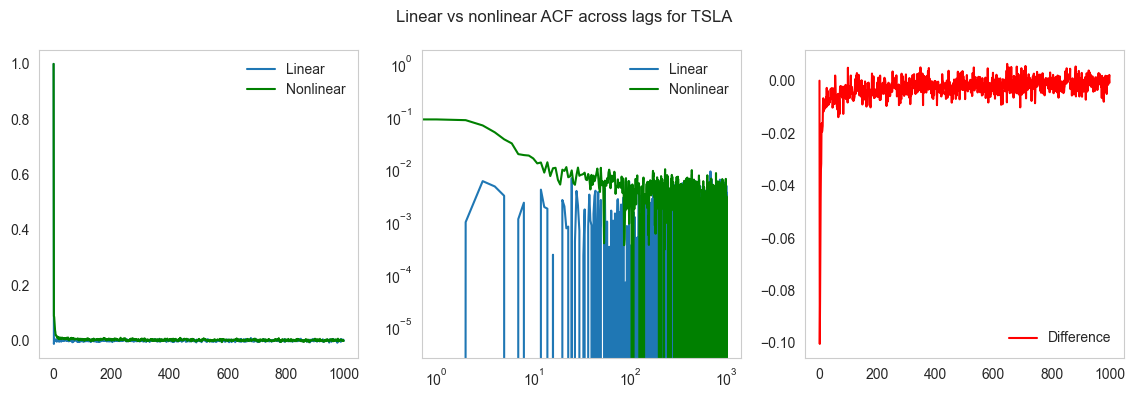

TSLA Max difference: 0.006408537399093777


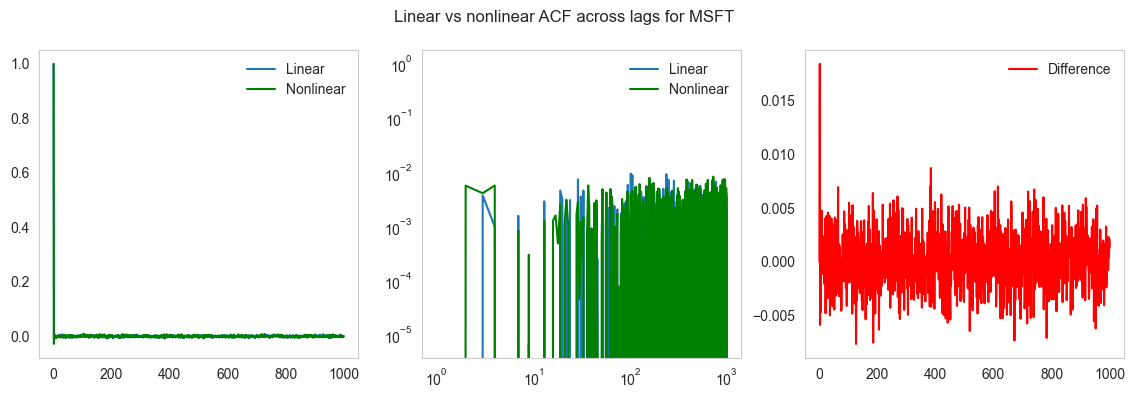

MSFT Max difference: 0.018416979648421337


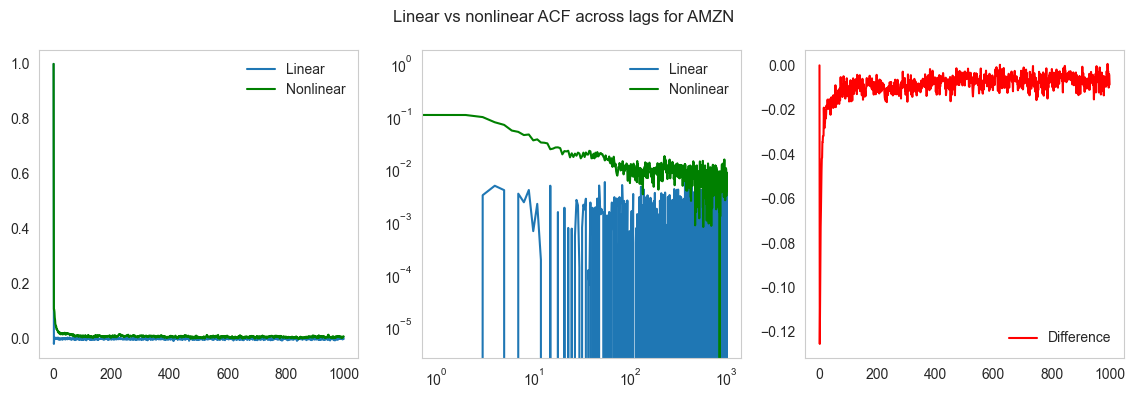

AMZN Max difference: 0.0006594702667207151


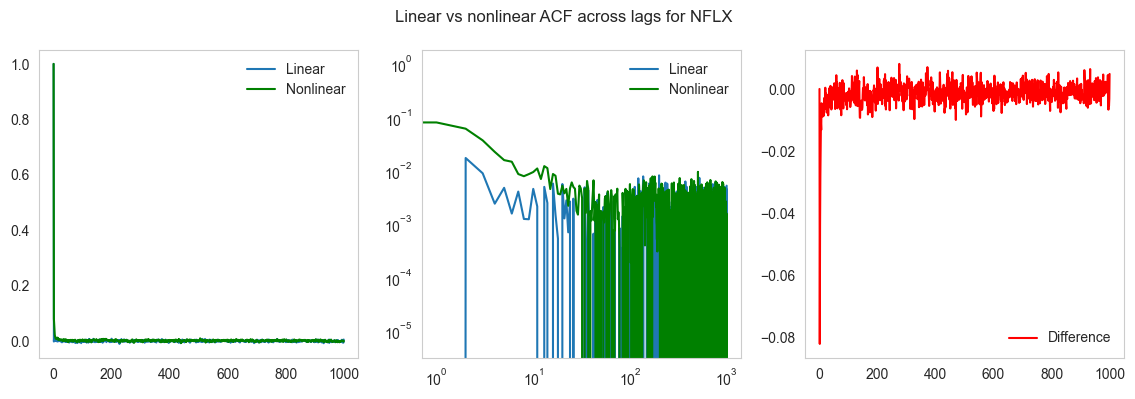

NFLX Max difference: 0.008073583397503534


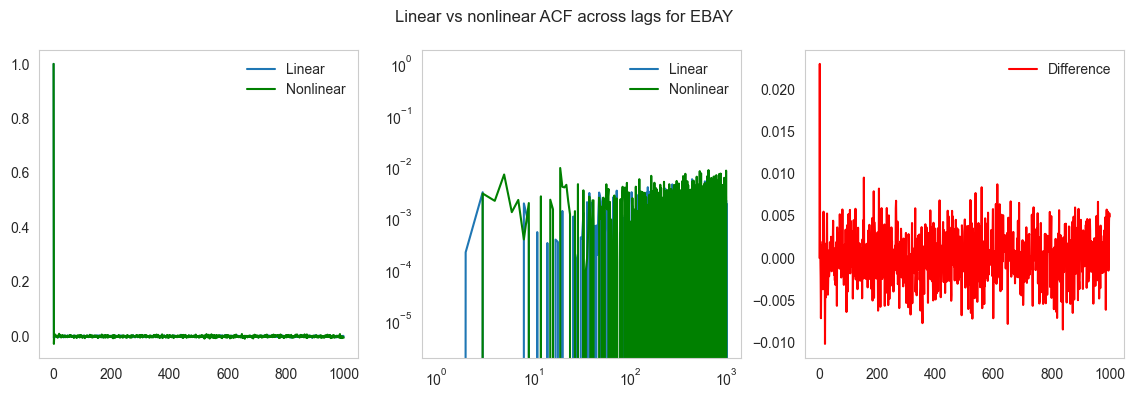

EBAY Max difference: 0.02301853831380277


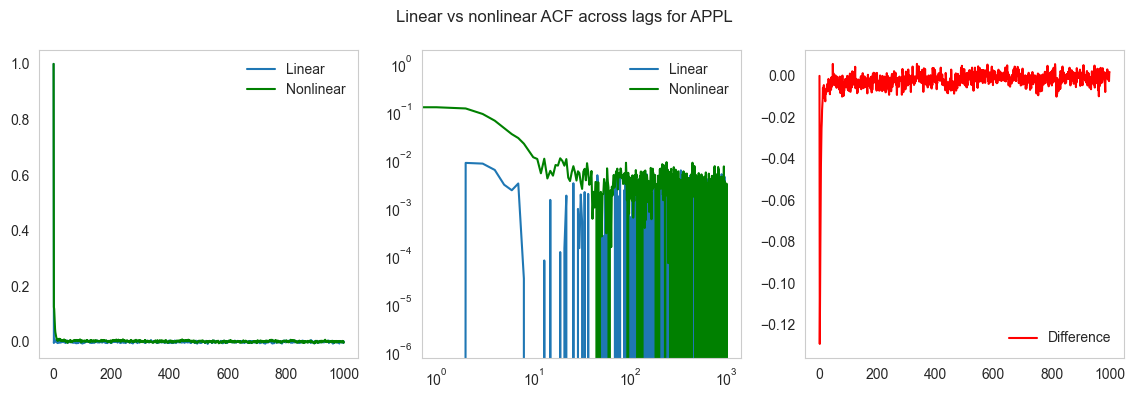

APPL Max difference: 0.005778153583539549


In [42]:
# Plot differences
# plot_acf_difference("TSLA", linear_acfs, nonlinear_acfs)
for stock_name in linear_acfs.keys():
    plot_acf_difference(stock_name, linear_acfs, nonlinear_acfs)

## 4. The Long Memory of Returns

To determine if a random process exhibits long memory, we take the following approach:

1. **Infer an Autocorrelation Function (ACF):** Start by inferring the ACF from a finite return sample.

2. **Fit a Power-law to the ACF:** Use the inferred ACF to fit a power-law.

3. **Estimate Hurst Exponent:** Use standard and generalized hurst on cumulative sum of raw series.

### 4.1. Estimate ACF scaling parameter

In [43]:
# TSLA Example
tsla_returns_acf = nonlinear_acfs['TSLA']
x = list(range(1, len(tsla_returns_acf) + 1))
xy_df = pd.DataFrame({"x_values": x, "y_values": tsla_returns_acf})

tsla_acf_fit = Fit(xy_df)
tsla_acf_fit.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 2
xmin: 3.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.17932633631685774
alpha = -0.8506021074297022

Goodness of fit to data;
D = 0.3173173173173173
bic = -11795.998415582806
mape = 202.09020998270515
Adjusted R-squared = 0.7021907284412539




### 4.1.2. For all assets

In [44]:
# Load the pre-computed ACFs
return_acf_values = {}

for stock, data in nonlinear_acfs.items():
    return_acf_values[stock] = construct_xy(data, stock)


In [45]:
# Using return_acf_values
fit_results_list = []
fit_objects = {}  # Dictionary to store fit objects

for stock, data in return_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[stock] = fit_obj  # Store the fit object

acf_fit_results = pd.DataFrame(fit_results_list)
display(acf_fit_results.head())

cannot unpack non-iterable NoneType object


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1793263...",2,3.0,0.317317,-11795.998416,202.090210,0.702191,-0.850602,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 69633.788...",708,709.0,0.505119,-3444.428118,98.836918,-0.009686,-3.088274,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0902039...",5,6.0,0.178715,-11578.170132,36.531173,0.676817,-0.410774,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0382684...",4,5.0,0.362086,-11940.805629,215.115098,0.177259,-0.612447,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -0.000195...",325,326.0,0.504438,-7865.429459,132.694827,-0.004464,0.000054,EBAY


In [46]:
fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [47]:
avg_gamma = acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_gamma}")

Average Gamma: -0.9362169100636423


In [48]:
# Retrieve the fit object for 'STOCK':
# tsla_acf_fit = fit_objects['AMZN']
# tsla_acf_fit.powerlaw.plot_fit()

### 4.2. Estimate Hurst Exponent

The Hurst Exponent, denoted by $H$, is a statistical measure of a time series which can be used to determine the nature of the series. Its value can range between 0 and 1:

- $H = 0.5$: The series is a random walk (Brownian motion). The future values do not depend on the past values.

- $H < 0.5$: The series has a tendency to revert to a mean, indicating negative autocorrelation. This is typical of "mean-reverting" series.

- $H > 0.5$: The series shows a trending behavior, meaning that increases (decreases) in the past will likely be followed by increases (decreases) in the future.

In [49]:
# TSLA Example
tsla_returns = compute_returns(tsla_raw_df)['cumsum_returns']

# Estimate Hurst Exponent using both Standard and Generalized metod
hurst_std, fit_std = standard_hurst(tsla_returns)
hurst_gen, fit_gen = generalized_hurst(tsla_returns)

fit_std.powerlaw.fit_results()
fit_gen.powerlaw.fit_results()

print(f"Standard Hurst Exponent: {hurst_std} ({interpret_hurst(hurst_std)})")
print(f"Generalized Hurst Exponent: {hurst_gen} ({interpret_hurst(hurst_gen)})")


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 1
xmin: 1.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.08878075715410834
alpha = 0.508993923594669

Goodness of fit to data;
D = 0.019562715765247412
bic = -10551.073137659814
mape = 0.3039840628666917
Adjusted R-squared = 0.9998873360358319



For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 28
xmin: 4.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.03435193222180402
alpha = 0.5866272248116898

Goodness of fit to data;
D = 0.010688836104513063
bic = -12636.526927697314
mape = 0.1914300187159466
Adjusted R-squared = 0.9999787658903939


Standard Hurst Exponent: 0.508993923594669 (Super-diffusive: series demonstrates persistent long-range dependence)
Generalized Hurst Exponent: 0.5866272248116898 (Super-diffusive: series demonstrates persistent long-range dependence)


### 4.2.1 For all assets

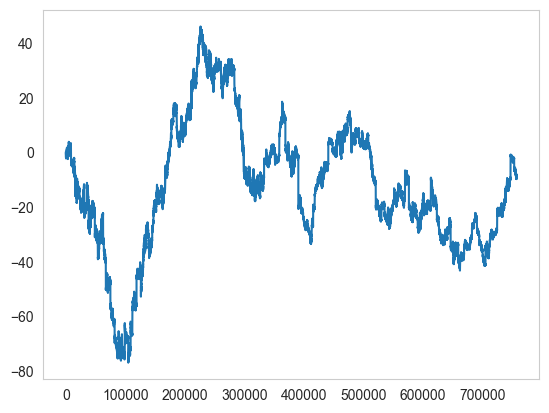

In [50]:
# Compute cumsum of returns as input for Hurst
tsla_cum_returns = compute_returns(tsla_raw_df)['cumsum_returns']
amzn_cum_returns = compute_returns(msft_raw_df)['cumsum_returns']
nflx_cum_returns = compute_returns(amzn_raw_df)['cumsum_returns']
msft_cum_returns = compute_returns(nflx_raw_df)['cumsum_returns']
ebay_cum_returns = compute_returns(ebay_raw_df)['cumsum_returns']
appl_cum_returns = compute_returns(appl_raw_df)['cumsum_returns']

cumsum_returns = {
  'TSLA': tsla_cum_returns,
  'MSFT': amzn_cum_returns,
  'AMZN': nflx_cum_returns,
  'NFLX': msft_cum_returns,
  'EBAY': ebay_cum_returns,
  'APPL': appl_cum_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_returns.items()}
x = list(range(1, len(tsla_cum_returns)+1))
plt.plot(x, tsla_cum_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [51]:
# Standard Hurst
method = 'standard'
fit_results_list = []
fit_objects = {}

for stock, data in cumsum_returns.items():
    fit_dict, fit = compute_hurst_exponent('returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[(stock, method, 'returns')] = fit

std_hurst_fit_results = pd.DataFrame(fit_results_list)
display(std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1145656...",1,1.0,0.031746,-3040.368136,0.727560,0.999213,0.510266,TSLA,returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0094922...",1,1.0,0.022222,-4675.859833,0.656646,0.999255,0.495638,MSFT,returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.2410204...",1,1.0,0.028571,-2793.443518,0.569582,0.999626,0.514030,AMZN,returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0417651...",1,1.0,0.022222,-3523.893856,0.993128,0.998639,0.503503,NFLX,returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0141333...",1,1.0,0.022222,-4738.437607,0.430865,0.999747,0.503954,EBAY,returns


In [52]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.5033475963575543


In [53]:
print(fit_objects.keys())

dict_keys([('TSLA', 'standard', 'returns'), ('MSFT', 'standard', 'returns'), ('AMZN', 'standard', 'returns'), ('NFLX', 'standard', 'returns'), ('EBAY', 'standard', 'returns'), ('APPL', 'standard', 'returns')])


In [54]:
# Retrieve standard Hurst fit object for specific 'STOCK'
# tsla_standard_fit = fit_objects[('TSLA', 'standard', 'returns')]
# tsla_standard_fit.powerlaw.plot_fit()

#### Generalized Hurst

In [55]:
# Generalized Hurst
method = 'generalized'
fit_results_list = []
fit_objects = {}

for stock, data in cumsum_returns.items():
    fit_dict, fit = compute_hurst_exponent('returns', stock, data, method=method,  max_lag=LAG)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[(stock, method, 'returns')] = fit

gen_hurst_fit_results = pd.DataFrame(fit_results_list)
display(gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/po

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0428193...",1,1.0,0.012698,-4037.703129,0.570835,0.999909,0.600000,TSLA,returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0046053...",5,2.0,0.012862,-5558.650038,0.383467,0.999898,0.538793,MSFT,returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0845996...",21,7.0,0.013559,-3783.744488,0.210818,0.999967,0.589635,AMZN,returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0196806...",1,1.0,0.019048,-4463.209948,0.739190,0.999826,0.557226,NFLX,returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0038501...",1,1.0,0.012698,-5818.442651,0.383010,0.999955,0.586856,EBAY,returns


In [56]:
# Generalized Hurst statistic across stocks
min_hurst_gen = gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5387928141913161
Max Generalized Hurst: 0.5999997080084587
Average Generalized Hurst: 0.5719970258010453
Standard_dev Generalized Hurst: 0.02363737149728893


In [57]:
print(fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'returns'), ('MSFT', 'generalized', 'returns'), ('AMZN', 'generalized', 'returns'), ('NFLX', 'generalized', 'returns'), ('EBAY', 'generalized', 'returns'), ('APPL', 'generalized', 'returns')])


In [58]:
# Retrieve generalized fit object for specific 'STOCK'
# msft_generalized_fit = fit_objects[('TSLA', 'generalized', 'returns')]
# msft_generalized_fit.powerlaw.plot_fit()